In [1]:
# IPython magig  tools
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../../../src/')

import os
from aind_vr_foraging_analysis.utils import parse, processing, plotting_utils as plotting, AddExtraColumns
from aind_vr_foraging_analysis.utils import breathing_signal as bs

# Plotting libraries
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
import pandas as pd
import numpy as np
import datetime

import matplotlib.patches as mpatches
import ipywidgets as widgets
from IPython.display import display
from matplotlib.patches import Rectangle

sns.set_context('talk')

import warnings
pd.options.mode.chained_assignment = None  # Ignore SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
from pathlib import Path

pdf_path = r'Z:\scratch\vr-foraging\sessions'
base_path = r'Z:\scratch\vr-foraging\data'
data_path = r'../../../data/'

color1='#d95f02'
color2='#1b9e77'
color3='#7570b3'
color4='#e7298a'
odor_list_color = [color1, color2, color3]
color_dict = {0: color1, 1: color2, 2: color3}
color_dict_label = {'Ethyl Butyrate': color1, 'Alpha-pinene': color2, 'Amyl Acetate': color3, 
                    '2-Heptanone' : color2, 'Methyl Acetate': color1, 'Fenchone': color3, '2,3-Butanedione': color4}

dict_odor = {}
rate = 1
offset = 1
dict_odor['Ethyl Butyrate'] = {'rate':rate, 'offset':offset, 'color': '#d95f02'}
dict_odor['Alpha-pinene'] = {'rate':rate, 'offset':offset, 'color': '#1b9e77'}
dict_odor['Amyl Acetate'] = {'rate':rate, 'offset':offset, 'color': '#7570b3'}
dict_odor['Methyl Acetate'] = {'rate':rate, 'offset':offset, 'color': color1}
dict_odor['2,3-Butanedione'] = {'rate':rate, 'offset':offset, 'color': color4}
dict_odor['Fenchone'] = {'rate':rate, 'offset':offset, 'color': '#7570b3'}
dict_odor['2-Heptanone'] = {'rate':rate, 'offset':offset, 'color': '#7570b3'}

# Define exponential function
def exponential_func(x, a, b):
    return a * np.exp(b * x)

def format_func(value, tick_number):
    return f"{value:.0f}"

results_path = r'C:\Users\tiffany.ona\OneDrive - Allen Institute\Documents\VR foraging\results'


In [2]:
pdf_path = r'C:\Users\tiffany.ona\OneDrive - Allen Institute\Documents\VR foraging\Data\figures'

date = datetime.date.today()
date_string = "09/03/2024"
date = datetime.datetime.strptime(date_string, "%m/%d/%Y").date()

mouse = '745302'

In [6]:
session_found = False

directory = os.path.join(base_path, mouse)
files = os.listdir(os.path.join(base_path, mouse))

sorted_files = sorted(files, key=lambda x: os.path.getctime(os.path.join(directory, x)), reverse=True)

# All this segment is to find the correct session without having the specific path
for file_name in sorted_files:
    
    if session_found == True:
        break
    
    # Find specific session sorted by date
    session = file_name[-15:-7]
    if datetime.datetime.strptime(session, "%Y%m%d").date() != date:
        continue
    else:
        print(file_name)
        session_found = True
        
    # Recover data streams
    session_path = os.path.join(base_path, mouse, file_name)
    session_path = Path(session_path)
    data = parse.load_session_data(session_path)
    
    # Parse data into a dataframe with the main features
    reward_sites, active_site, config = parse.parse_dataframe(data)
    # -- At this step you can save the data into a csv file
    
    # Expand with extra columns
    reward_sites = AddExtraColumns(reward_sites, active_site, run_on_init=True).reward_sites
    active_site = AddExtraColumns(reward_sites, active_site, run_on_init=False).add_time_previous_intersite_interpatch()

    # Load the encoder data separately
    stream_data = parse.ContinuousData(data)
    encoder_data = stream_data.encoder_data
    breathing = stream_data.breathing

if session_found == False:
    print('Session not found')

745302_20240903T114159


In [ ]:
# breathing = processing.fir_filter(stream_data.breathing, 'data', 100)

label_dict = {**{
    "InterSite": '#808080',
    "InterPatch": '#b3b3b3'}, 
              **color_dict_label}

def update_plot(x_start):
    zero_index = active_site.index[0]

    fig, axs = plt.subplots(2,1, figsize=(12,8), gridspec_kw={'height_ratios': [2, 3]}, sharex=True)

    # sites_test = sites.loc[(sites.index > (zero_index + x_start))&(sites.index < (zero_index + x_start + 50))]   
    _legend = {}
    for idx, site in enumerate(active_site.iloc[:-1].iterrows()):
        site_label = site[1]["label"]
        if site_label == "Reward":
            site_label = f"Odor {site[1]['odor']['index']+1}"
            facecolor = label_dict[site_label]
        elif site_label == "RewardSite":
            site_label = site[1]['odor_label']
            facecolor = label_dict[site_label]
        elif site_label == "InterPatch":
            facecolor = label_dict[site_label]
        else:
            site_label = "InterSite"
            facecolor = label_dict["InterSite"]

        p = Rectangle(
            (active_site.index[idx] - zero_index, -2), active_site.index[idx+1] - active_site.index[idx], 8,
            linewidth = 0, facecolor = facecolor, alpha = .5)
        
        _legend[site_label] = p
        axs[0].add_patch(p)
        
        q = Rectangle(
            (active_site.index[idx] - zero_index, -2), active_site.index[idx+1] - active_site.index[idx], 8,
            linewidth = 0, facecolor = facecolor, alpha = .5)
        _legend[site_label] = q
        axs[1].add_patch(q)
        # axs[1].add_patch(p)
        
    s, lw = 400, 2
    # Plotting raster
    y_idx = -0.4
    _legend["Choice Tone"] = axs[1].scatter(stream_data.choice_feedback.index - zero_index+0.2,
            stream_data.choice_feedback.index * 0 + y_idx,
            marker="s", s=100, lw=lw, c='darkblue',
            label="Choice Tone")
    y_idx += 1
    _legend["Lick"] = axs[1].scatter(stream_data.lick_onset.index - zero_index,
            stream_data.lick_onset.index * 0 + y_idx,
            marker="|", s=s, lw=lw, c='k',
            label="Lick")
    _legend["Reward"] = axs[1].scatter(stream_data.give_reward.index - zero_index,
            stream_data.give_reward.index*0 + y_idx,
            marker=".", s=s, lw=lw, c='deepskyblue',
            label="Reward")
    
    y_idx += 1

    #ax.set_xticks(np.arange(0, sites.index[-1] - zero_index, 10))
    axs[1].set_yticklabels([])
    axs[1].set_xlabel("Time(s)")
    axs[1].set_ylim(bottom=-1, top = 3)
    axs[1].grid(False)

    ax2 = axs[1].twinx()
    _legend["Velocity"] = ax2.plot(encoder_data.index - zero_index, encoder_data.filtered_velocity, c="k", label="Encoder", alpha = 0.8)[0]
    try:
        v_thr = config.streams.TaskLogic.data["operationControl"]["positionControl"]["stopResponseConfig"]["velocityThreshold"]
    except:
        v_thr = 8
    _legend["Stop Threshold"] = ax2.plot(ax2.get_xlim(), (v_thr, v_thr), c="k", label="Encoder", alpha = 0.5, lw = 2, ls = "--")[0]
    ax2.grid(False)
    ax2.set_ylim((-5, 70))
    ax2.set_ylabel("Velocity (cm/s)")

    ax3 = axs[0].twinx()
    _legend["Breathing"] = ax3.plot(breathing.index - zero_index, breathing.data.values, c="black", label="Breathing", alpha = 0.8)[0]
    # _legend["Breathing"] = ax3.plot(filtered_breathing.index - zero_index, filtered_breathing['data'].values, c="black", label="Breathing", alpha = 0.8)[0]

    ax3.grid(False)
    # ax3.set_ylim(breathing.filtered_data.quantile(0.001), breathing.filtered_data.quantile(0.999))
    ax3.set_ylabel("Breathing (au)")
    
    axs[0].legend(_legend.values(), _legend.keys(), bbox_to_anchor=(1.2, 0.1), loc='center left', borderaxespad=0.)

    # axs[0].stairs(software_events.streams.RewardAvailableInPatch.data["data"].values[:-1],
    #           software_events.streams.RewardAvailableInPatch.data["data"].index.values -  zero_index,
    #           lw = 3, color = 'k', fill=0)
    
    for i in [0,1]:
        axs[i].set_xlabel("Time(s)")
        axs[i].grid(False)
        axs[i].set_ylim(bottom=-1, top = 4)
        axs[i].set_yticks([])
        axs[i].yaxis.tick_right()
        axs[i].set_xlim([x_start, x_start + 15])
        
    # plt.savefig(foraging_figures + f"\{x_start_widget.value}_time_detrended.svg", bbox_inches='tight', pad_inches=0.1, transparent=True)
    
# Define callback functions for the arrow buttons
def on_left_button_clicked(button):
    x_start_widget.value -= 5

def on_right_button_clicked(button):
    x_start_widget.value += 5

# Create arrow buttons
left_button = widgets.Button(description='◄')
right_button = widgets.Button(description='►')

# Define widget for the starting value of x-axis
x_start_widget = widgets.FloatText(value=00.0, description='X start:', continuous_update=False)

# Set button click event handlers
left_button.on_click(on_left_button_clicked)
right_button.on_click(on_right_button_clicked)

# Arrange the buttons and widget horizontally
button_box = widgets.HBox([left_button, right_button])
ui = widgets.VBox([button_box, x_start_widget])

# Create interactive plot
interactive_plot = widgets.interactive_output(update_plot, {'x_start': x_start_widget})

# Display the interactive plot and UI
display(ui, interactive_plot)

Output()

**Evaluate signal**

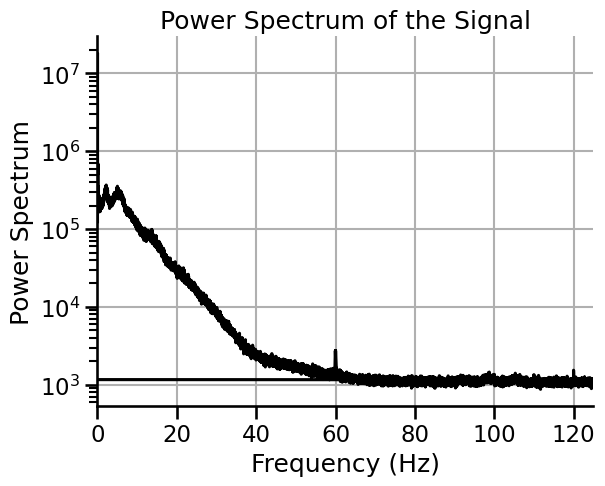

In [10]:
bs.plot_FFT(breathing.data, fs=250, color="black", label="test")

## Explore ways of filtering the signal
We can either have a bandpass filter applied or a running averaged smoothed and then substracted to the signal

suggested by Carl:
- zero-phase third-order IIR Butterworth filter (1 to 125 Hz)  [goal: isolate frequency components relevant to the breathing cycle]
- zero-phase second-order IIR notch filters (120, 60 and 100 Hz) with bandwidth = notch-frequency/35 [goal: cut mains hum if present--maybe first run an FFT to see if this is a problem]
- second-order FIR Savitsky-Golay filter at 35 millisecond frame length [goal: smoothing]

In [16]:
t = breathing.index
signal = breathing.data

# Define filter parameters
# cutoff_freq = 50  # cutoff frequency in Hz
# signal = bs.lowpass_filter (signal, cutoff_freq, fs)

signal = bs.apply_notch_filter(signal)

### Filter using bandpass

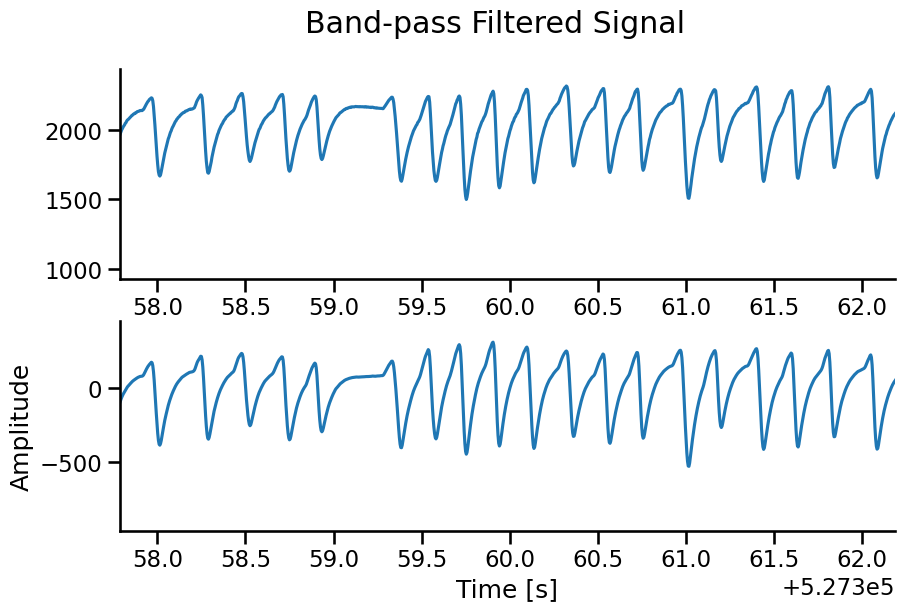

In [18]:
import numpy as np
import matplotlib.pyplot as plt

filtered_breathing_bp = breathing.copy()

# Define filter parameters
cutoff_freq = 1  # cutoff frequency in Hz
fs = 250  # sampling frequency in Hz

# Apply high-pass filter
filtered_breathing = bs.highpass_filter(signal, cutoff_freq, fs)

cutoff_freq = 50  # cutoff frequency in Hz
filtered_breathing = bs.lowpass_filter(filtered_breathing, cutoff_freq, fs)

# Plot original and filtered signals
plt.figure(figsize=(10, 6))

# Plot the detrended signal
plt.subplot(2, 1, 1)
plt.plot(t, signal, label='Original Signal')
plt.xlim(t[2000],t[3100])

# Plot the detrended signal
plt.subplot(2, 1, 2)
plt.plot(t, filtered_breathing, label='Filtered Signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.suptitle('Band-pass Filtered Signal')
plt.xlim(t[2000],t[3100])
sns.despine()
plt.show()

filtered_breathing_bp['data'] = filtered_breathing


### Filter using smoothing average

AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

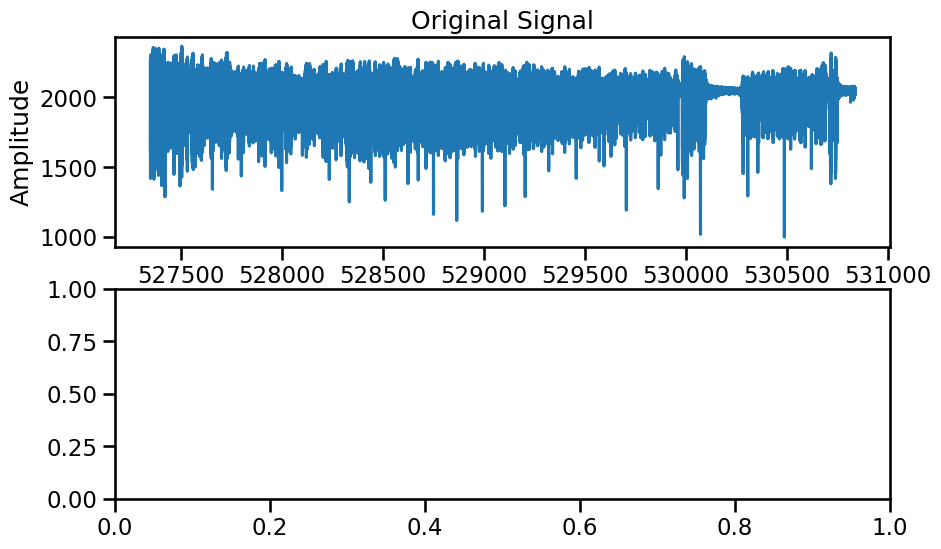

In [19]:
# Remove Slow oscillations
window_size=75
slow_ther = bs.moving_average(signal, window_size=window_size)
new_ther = signal-slow_ther

# Plot the original signal
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(t, signal, label='Original Signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Original Signal')

# Plot the detrended signal
plt.subplot(2, 1, 2)
plt.plot(t[int(window_size/2):-int(window_size/2)], new_ther.iloc[int(window_size/2):-int(window_size/2)], label='Detrended Signal', color='black')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.xlim(t[2000],t[3100])

# Plot the detrended signal
plt.subplot(2, 1, 1)
plt.plot(t[int(window_size/2):-int(window_size/2)], slow_ther[int(window_size/2):-int(window_size/2)], label='Detrended Signal', color='black')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Moving Signal')
plt.xlim(t[2000],t[3100])
sns.despine()
breathing['data'] = new_ther

### Filter using Savitkzy-golay

In [20]:
# filtered_breathing = signal

slow_ther = scipy.signal.savgol_filter(filtered_breathing, 125, 2)
filtered_breathing_sg = filtered_breathing-slow_ther

# Plot original and filtered signals
plt.figure(figsize=(10, 6))

# Plot the detrended signal
plt.subplot(2, 1, 1)
plt.plot(t, filtered_breathing, label='Original Signal')
plt.plot(t, slow_ther,  c='black')
plt.xlim(t[4000],t[5000])

# Plot the detrended signal
plt.subplot(2, 1, 2)
plt.plot(t, filtered_breathing_sg, label='Filtered Signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.suptitle('Savitkzy-Golay Filtered Signal')
plt.xlim(t[4000],t[5000])
sns.despine()
plt.show()


NameError: name 'scipy' is not defined

### Compare filtering signals

In [ ]:
def compare_signals(time):
    time = int(time)
    
    # Plot original and filtered signals
    plt.figure(figsize=(10, 6))

    # Plot the detrended signal
    plt.subplot(1, 1, 1)
    plt.plot(t, filtered_breathing_bp, label='Band-pass', alpha=0.8)
    plt.plot(t, new_ther, alpha=0.8, label='Moving average')
    plt.plot(t, filtered_breathing_sg, label='Savitkzy-Golay', alpha=0.8, color='black')
    plt.ylim(-100,100)
    plt.legend()
    plt.xlim(t[time],t[time+250])
    sns.despine()
    
def on_left_button_clicked(button):
    time.value -= 250

def on_right_button_clicked(button):
    time.value += 250

# Create arrow buttons
left_button = widgets.Button(description='◄')
right_button = widgets.Button(description='►')

# Define widget for the starting value of x-axis
time = widgets.FloatText(value=00.0, description='Time:', continuous_update=False)

# Set button click event handlers
left_button.on_click(on_left_button_clicked)
right_button.on_click(on_right_button_clicked)

# Arrange the buttons and widget horizontally
button_box = widgets.HBox([left_button, right_button])
ui = widgets.VBox([button_box, x_start_widget])

# Create interactive plot
interactive_plot = widgets.interactive_output(compare_signals, {'time': time})

# Display the interactive plot and UI
display(ui, interactive_plot)

### Compare the two signals one on top of each other

In [ ]:
reward_sites['total_sites'] = np.arange(len(reward_sites))
reward_sites['odor_duration'] = reward_sites['odor_offset'] - reward_sites['odor_onset']
## Check the 

In [ ]:
window = (-1,1)
align = 'odor_onset'
# trial_summary = plotting.trial_collection(reward_sites, breathing, mouse, session, aligned='odor_onset', window=window, taken_col='data')
trial_summary_highpass = plotting.trial_collection(reward_sites[['has_choice', 'total_sites', 'odor_label','odor_duration', 'visit_number', align]], 
                                                   filtered_breathing, mouse, session, aligned=align, window=window, taken_col='data')

if align == 'odor_offset':
    trial_summary_highpass['odor_onset'] = trial_summary_highpass['times'] - trial_summary_highpass['odor_duration']
    trial_summary_highpass['odor_onset'] = np.where(trial_summary_highpass.odor_duration < abs(window[0]), - trial_summary_highpass.odor_duration, window[0])
    
else:
    print('Here')
    trial_summary_highpass['odor_offset'] =  trial_summary_highpass['odor_duration']
    trial_summary_highpass['odor_offset'] = np.where(trial_summary_highpass.odor_offset > window[1], window[1], trial_summary_highpass.odor_offset)

In [ ]:
def plot_sniff(total_site):
        
    # Plot the signal
    fig, ax = plt.subplots(1,1, figsize= (8,6), sharex=True)
 
    # total_sites_df = trial_summary.loc[trial_summary.total_sites == total_site]
    # time = total_sites_df['times']
    # signal = total_sites_df['data']
    # plt.plot(time, signal)
    
    color = color_dict_label[trial_summary_highpass.odor_label.unique()[0]]

    total_sites_df = trial_summary_highpass.loc[trial_summary_highpass.total_sites == total_site]
    time = total_sites_df['times']
    signal = total_sites_df['data']
    max_signal = max(trial_summary_highpass.data.values)
    min_signal = min(trial_summary_highpass.data.values)
    
    # Plot the signal
    ax.plot(time, signal, color='black')
    ax.set_title(f'Stop: {total_sites_df.has_choice.unique()[0]} Odor: {total_sites_df.odor_label.unique()[0]}  Odor site: {total_sites_df.visit_number.unique()[0]}')
    ax.set_ylabel('Amplitude (a.u.)')
    ax.vlines(0, min_signal, max_signal, color='black', linestyles = ':')

    if align == 'odor_onset':
        ax.fill_betweenx(np.arange(min_signal,max_signal,0.1), 0, total_sites_df['odor_offset'].unique(), color=color, alpha=.5, linewidth=0)
    else:
        ax.fill_betweenx(np.arange(min_signal,max_signal,0.1), total_sites_df['odor_onset'].unique(), 0, color=color, alpha=.5, linewidth=0)
    sns.despine()
    plt.show()

def on_left_button_clicked(button):
    x_start_widget.value -= 1

def on_right_button_clicked(button):
    x_start_widget.value += 1

# Create arrow buttons
left_button = widgets.Button(description='◄')
right_button = widgets.Button(description='►')

# Define widget for the starting value of x-axis
x_start_widget = widgets.FloatText(value=00.0, description='Site:', continuous_update=False)

# Set button click event handlers
left_button.on_click(on_left_button_clicked)
right_button.on_click(on_right_button_clicked)

# Arrange the buttons and widget horizontally
button_box = widgets.HBox([left_button, right_button])
ui = widgets.VBox([button_box, x_start_widget])

# Create interactive plot
interactive_plot = widgets.interactive_output(plot_sniff, {'total_site': x_start_widget})

# Display the interactive plot and UI
display(ui, interactive_plot)


In [ ]:
def plot_sniff(total_site):
    if align == 'odor_onset':
        trial_summary_highpass['odor_onset']
        
    # Plot the signal
    fig, ax = plt.subplots(1,1, figsize= (8,6), sharex=True)
 
    # total_sites_df = trial_summary.loc[trial_summary.total_sites == total_site]
    # time = total_sites_df['times']
    # signal = total_sites_df['data']
    # plt.plot(time, signal)
    
    color = color_dict_label[trial_summary_highpass.odor_label.unique()[0]]

    total_sites_df = trial_summary_highpass.loc[trial_summary_highpass.total_sites == total_site]
    time = total_sites_df['times']
    signal = total_sites_df['data']
    max_signal = max(trial_summary_highpass.data.values)
    min_signal = min(trial_summary_highpass.data.values)
    
    # Plot the signal
    ax.plot(time, signal, color='black')
    ax.set_title(f'Stop: {total_sites_df.has_choice.unique()[0]} Odor: {total_sites_df.odor_label.unique()[0]}  Odor site: {total_sites_df.visit_number.unique()[0]}')
    ax.set_ylabel('Amplitude (a.u.)')
    ax.vlines(0, min_signal, max_signal, color='black', linestyles = ':')

    ax.fill_betweenx(np.arange(min_signal,max_signal,0.1), total_sites_df['odor_onset'].unique(), 0, color=color, alpha=.5, linewidth=0)
    sns.despine()
    plt.show()

def on_left_button_clicked(button):
    x_start_widget.value -= 1

def on_right_button_clicked(button):
    x_start_widget.value += 1

# Create arrow buttons
left_button = widgets.Button(description='◄')
right_button = widgets.Button(description='►')

# Define widget for the starting value of x-axis
x_start_widget = widgets.FloatText(value=00.0, description='Site:', continuous_update=False)

# Set button click event handlers
left_button.on_click(on_left_button_clicked)
right_button.on_click(on_right_button_clicked)

# Arrange the buttons and widget horizontally
button_box = widgets.HBox([left_button, right_button])
ui = widgets.VBox([button_box, x_start_widget])

# Create interactive plot
interactive_plot = widgets.interactive_output(plot_sniff, {'total_site': x_start_widget})

# Display the interactive plot and UI
display(ui, interactive_plot)


In [ ]:
def plot_sniff(total_site):
    
    # Plot the signal
    fig, ax = plt.subplots(2,1, figsize= (10,7), sharex=True)
 
    # total_sites_df = trial_summary.loc[trial_summary.total_sites == total_site]
    # time = total_sites_df['times']
    # signal = total_sites_df['data']
    # plt.plot(time, signal)

    total_sites_df = trial_summary_highpass.loc[trial_summary_highpass.total_sites == total_site]
    time = total_sites_df['times']
    signal = total_sites_df['data']
    
    # Plot the signal
    ax[0].plot(time, signal, color='black')
    ax[0].set_title(f'Stop: {total_sites_df.has_choice.unique()[0]} Odor: {total_sites_df.odor_label.unique()[0]}  Odor site: {total_sites_df.visit_number.unique()[0]}')
    ax[0].set_ylabel('Amplitude (a.u.)')
    ax[0].vlines(0, min(trial_summary_highpass.data.values),max(trial_summary_highpass.data.values), color='black', linestyles = ':')

    # Power spectrum
    fs = 250  # Sampling frequency

    Pxx, frequencies, bins, im = plt.specgram(signal, NFFT=250, Fs=fs, noverlap=249)

    # Plot spectrogram
    ax[1].set_ylabel('Frequency (Hz)')
    ax[1].set_title('Power Spectrogram')
    ax[1].set_ylim(0,30)
    ax[1].set_xlim(-2,2)
    ax[1].set_xlabel('Time from odor onset (s)')

    time_corrected = np.linspace(window[0], 500 / fs, len(bins))

    ax[1].pcolormesh(time_corrected, frequencies, 20 * np.log10(Pxx),  vmin=-10, vmax=30, cmap = 'rocket', shading="gouraud", rasterized=True)  # Plot the spectrogram with the corrected time axis

    # plt.colorbar(label='Power (dB)')

    sns.despine()
    plt.show()

def on_left_button_clicked(button):
    x_start_widget.value -= 1

def on_right_button_clicked(button):
    x_start_widget.value += 1

# Create arrow buttons
left_button = widgets.Button(description='◄')
right_button = widgets.Button(description='►')

# Define widget for the starting value of x-axis
x_start_widget = widgets.FloatText(value=00.0, description='Site:', continuous_update=False)

# Set button click event handlers
left_button.on_click(on_left_button_clicked)
right_button.on_click(on_right_button_clicked)

# Arrange the buttons and widget horizontally
button_box = widgets.HBox([left_button, right_button])
ui = widgets.VBox([button_box, x_start_widget])

# Create interactive plot
interactive_plot = widgets.interactive_output(plot_sniff, {'total_site': x_start_widget})

# Display the interactive plot and UI
display(ui, interactive_plot)


In [ ]:

total_site = 10
total_sites_df = trial_summary_highpass.loc[trial_summary_highpass.total_sites == total_site]
time = total_sites_df['times']
signal = total_sites_df['data']

# Power spectrum
fs = 250  # Sampling frequency

Pxx, frequencies, bins, im = plt.specgram(signal, NFFT=250, Fs=fs, noverlap=249)


time_corrected = np.linspace(window[0], 500 / fs, len(bins))

plt.pcolormesh(time_corrected, frequencies, 20 * np.log10(Pxx),  vmin=-10, vmax=35, cmap = 'rocket', shading="gouraud", rasterized=True)  # Plot the spectrogram with the corrected time axis
plt.colorbar(label='Power (dB)')


### Average the signal across epochs

In [ ]:
df = pd.DataFrame()
Pxx_accum = None
n_epochs = trial_summary_highpass.total_sites.nunique()

for trial in trial_summary_highpass.total_sites.unique():
    trial_average = pd.DataFrame()
    
    total_sites_df = trial_summary_highpass.loc[(trial_summary_highpass.total_sites == trial)]
    time = total_sites_df['times']
    signal = total_sites_df['data']

    fs = 250  # Sampling frequency

    Sxx, frequencies, bins, im = plt.specgram(signal, NFFT=250, Fs=fs, noverlap=249)
    time_corrected = np.linspace(-1, len(signal) / fs, len(bins))
    
    # Accumulate the Sxx values
    if Pxx_accum is None:
        Pxx_accum = np.zeros_like(Sxx)
    
    # Ensure the shapes match by trimming or padding
    if Sxx.shape != Pxx_accum.shape:
        min_shape = np.minimum(Pxx_accum.shape, Sxx.shape)
        Pxx_accum = Pxx_accum[:min_shape[0], :min_shape[1]]
        Sxx = Sxx[:min_shape[0], :min_shape[1]]
    
    Pxx_accum += Sxx
    
    peak_indices = np.argmax(Sxx, axis=0)
    peak_frequencies = frequencies[peak_indices]
    peak_amplitudes = Sxx[peak_indices][0]

    trial_average['freq'] =  peak_frequencies
    trial_average['amplitude'] =  peak_amplitudes    
    trial_average['t'] = np.arange(window[0], window[1], (window[1]-window[0])/len(peak_frequencies))

    for column in trial_summary_highpass.columns:
        trial_average[column] = np.repeat(total_sites_df[column].unique()[0], trial_average.shape[0])
        
    df = pd.concat([df, trial_average], ignore_index=True)

In [ ]:
# Compute the average Pxx
Pxx_avg = Pxx_accum / num_epochs

In [ ]:
# Plot the average spectrogram
plt.figure()
plt.pcolormesh(bins, frequencies, 10 * np.log10(Pxx_avg))
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title('Average Spectrogram')
plt.colorbar(label='Intensity [dB]')
plt.show()

In [ ]:
df['t'] = np.around(df['t'],3)

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(12,5), sharex=True)
sns.lineplot(x='t', y='freq', data=df.loc[(df.visit_number == 0)&(df.odor_label == 'Ethyl Butyrate')], hue='has_choice', errorbar='sd', ax= ax[0], legend=False)
sns.lineplot(x='t', y='amplitude', data=df.loc[(df.visit_number == 0)&(df.odor_label == 'Ethyl Butyrate')], hue='has_choice', errorbar='sd', ax= ax[1])

ax[0].vlines(0, 2, 10, color='black', linestyles = ':')
ax[1].vlines(0, 0, 100, color='black', linestyles = ':')
ax[1].set_ylim(-20,150)

plt.tight_layout()
sns.despine()

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(12,5), sharex=True)
sns.lineplot(x='t', y='freq', data=df.loc[(df.visit_number == 0)&(df.has_choice == False)], hue='odor_label', errorbar='sd', ax= ax[0], legend=False)
sns.lineplot(x='t', y='amplitude', data=df.loc[(df.visit_number == 0)&(df.has_choice == False)], hue='odor_label', errorbar='sd', ax= ax[1])

ax[0].vlines(0, 4, 10, color='black', linestyles = ':')
ax[1].vlines(0, 0, 100, color='black', linestyles = ':')
ax[1].set_ylim(-20,150)

plt.tight_layout()
sns.despine()

In [ ]:
breathing.index = pd.to_datetime(breathing.index, unit="s")
breathing = breathing.resample("4ms").sum().interpolate(method="linear") / 0.004
breathing.index = (breathing.index - pd.to_datetime(0))
breathing.index = breathing.index.total_seconds()

In [ ]:
# Pivot the DataFrame to have trials as rows, time as columns, and frequency as values
pivot_df = df.pivot(index='total_sites', columns='t', values='freq').interpolate(method='linear', axis=1)
# pivot_df = pivot_df.sort_values(by=-2.842170943040401e-14, ascending=False)

# Sort the DataFrame by the amplitude column
# sorted_df = pivot_df.sort_values(by='freq')
plt.figure(figsize=(14, 8))
plt.imshow(pivot_df.values, aspect='auto', cmap='viridis', origin='upper', vmin=0, vmax=15)
plt.vlines(x=0, ymin=0, ymax=300)

# plt.xticks(np.arange(0, df_sorted.shape[1], 0.25), np.array(df_sorted.columns))
# plt.locator_params(axis='x', nbins=15)

# Plot heatmap
# heatmap = sns.heatmap(data=df_sorted, cmap='viridis')
plt.colorbar(label='Amplitude')

In [ ]:
# Pivot the DataFrame to have trials as rows, time as columns, and frequency as values
pivot_df = df.loc[(df['has_choice']==True)&(df['visit_number']==0)&(df['odor_label']=='Ethyl Butyrate')].pivot(index='total_sites', columns='t', values='freq').interpolate(method='linear', axis=1)
# pivot_df = pivot_df.sort_values(by=-0.08255659121174475, ascending=False)

# Sort the DataFrame by the amplitude column
fig, ax = plt.subplots(1,2, figsize=(18, 6))
ax[0].imshow(pivot_df.values, aspect='auto', cmap='icefire', origin='upper', vmin=0, vmax=12)
ax[0]. set_title('First visit stop')
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Odor site')
ax[0].set_xticks(np.arange(0, pivot_df.shape[1], 1), np.array(pivot_df.columns))
ax[0].locator_params(axis='x', nbins=6)

# Pivot the DataFrame to have trials as rows, time as columns, and frequency as values
pivot_df = df.loc[(df['has_choice']==False)&(df['visit_number']==0)&(df['odor_label']=='Ethyl Butyrate')].pivot(index='total_sites', columns='t', values='freq').interpolate(method='linear', axis=1)
# pivot_df = pivot_df.sort_values(by=-0.08255659121174475, ascending=False)

# Sort the DataFrame by the amplitude column
ax[1].imshow(pivot_df.values, aspect='auto', cmap='icefire', origin='upper', vmin=0, vmax=12)
ax[1].set_title('Disengaged run-thru ')
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('Odor site')
ax[1].set_xticks(np.arange(0, pivot_df.shape[1], 1), np.array(pivot_df.columns))
plt.locator_params(axis='x', nbins=6)

# Plot heatmap
plt.imshow(pivot_df.values, aspect='auto', cmap='icefire', origin='upper', vmin=0, vmax=12)
plt.colorbar(label='freq')

## Explore acquired data and find good and bad sessions for thermistor data

In [ ]:
date_string = "2/25/2024"
date = datetime.datetime.strptime(date_string, "%m/%d/%Y").date()

In [ ]:
summary_df = pd.DataFrame()

for mouse in ["694569", "690164", "715866", "713578", "707349", "716455", "716458","715865","715869","713545","715867","715870","716456","716457"]:
    # Save each figure to a separate page in the PDF
    with PdfPages(pdf_path+"\\"+mouse+'.pdf') as pdf:
        directory = os.path.join(base_path, mouse)
        files = os.listdir(os.path.join(base_path, mouse))
        print(mouse)
        sorted_files = sorted(files, key=lambda x: os.path.getctime(os.path.join(directory, x)), reverse=True)

        for file_name in sorted_files:
                
            print(file_name)
            session_path = os.path.join(base_path, mouse, file_name)
            session = file_name[:8]
            session_path = Path(session_path)
            
            if datetime.date.fromtimestamp(os.path.getctime(session_path)) < date:
                break
                
            try:
                data = analysis.load_session_data(session_path)
            except:
                continue


            data['harp_behavior'].streams.OutputSet.load_from_file()
            data['harp_behavior'].streams.OutputClear.load_from_file()
            
            fig, ax = plt.subplots(1,1, figsize=(10,4), sharex=True)
            plt.suptitle(f'{mouse}_{session}')
            if 'harp_sniffsensor' in data:
                print('plot harp sniff sensor')
                data['harp_sniffsensor'].streams.RawVoltage.load_from_file()
                zero_index = data['harp_sniffsensor'].streams.RawVoltage.data['RawVoltage'].index[0]
                ax.plot(data['harp_sniffsensor'].streams.RawVoltage.data['RawVoltage'].index-zero_index, data['harp_sniffsensor'].streams.RawVoltage.data['RawVoltage'].values)
                
                ## Breathing
                breathing = pd.DataFrame(index = data['harp_sniffsensor'].streams.RawVoltage.data['RawVoltage'].index, columns=['data'])
                breathing['data'] = data['harp_sniffsensor'].streams.RawVoltage.data['RawVoltage'].values
                
            else:
                print('plot analog sniff sensor')
                data['harp_behavior'].streams.AnalogData.load_from_file()      
                zero_index = data['harp_behavior'].streams.AnalogData.data['AnalogInput0'].index[0]
                ax.plot(data['harp_behavior'].streams.AnalogData.data['AnalogInput0'].index-zero_index, data['harp_behavior'].streams.AnalogData.data['AnalogInput0'].values)
                
                ## Breathing
                breathing = pd.DataFrame(index = data['harp_behavior'].streams.AnalogData.data['AnalogInput0'].index, columns=['data'])
                breathing['data'] = data['harp_behavior'].streams.AnalogData.data['AnalogInput0'].values
                
            ax.set_xlim(250, 255)
            # ax[0].set_ylim(2200, 2300)
            sns.despine()        
            plt.show()
            pdf.savefig(fig, bbox_inches='tight')


## Rewarded or non-rewarded stop?

In [ ]:
stop_sites = reward_sites.loc[reward_sites['has_choice'] == True]
window = (-1,2)

In [ ]:
trial_summary = plotting.trial_collection(stop_sites, breathing, mouse, session, aligned='stop_time', window=window, taken_col='data')

In [ ]:
pdf_path = r'C:\Users\tiffany.ona\OneDrive - Allen Institute\Documents\VR foraging\Data\figures'

condition = 'reward_delivered'
colors_reward=sns.color_palette("Greys", n_colors=trial_summary[condition].nunique())
palette_dict = dict(zip(sorted(trial_summary[condition].unique()), colors_reward))

n_odors = trial_summary.odor_label.unique()
fig, ax1 = plt.subplots(1,len(n_odors)+1, figsize=((len(n_odors)+1)*5, 5), sharex=True, sharey=True)
colors = ['orange','darkgreen', 'indigo']
legend=True
for j, odor_label in enumerate(n_odors):
    ax1[0].set_ylabel('Breathing (a.u.)')
    ax1[j].set_xlabel('Time after odor onset (s)')
    ax1[j].set_xlim(window)
    ax1[j].set_ylim(2000,2100)
    ax1[j].fill_betweenx(np.arange(2000,trial_summary['speed'].max(),0.1), 0,0.05, color='#808080', alpha=.5, linewidth=0)
    
    df_results = (trial_summary.loc[(trial_summary.odor_label == odor_label)]
                .groupby([condition,'times'])[['speed']].mean().reset_index())
    
    if df_results.empty:
        continue
    
    for site in df_results[condition].unique():
        plot_df = df_results.loc[df_results[condition]==site]

        sns.lineplot(x='times', y='speed', data=plot_df,  color = palette_dict[site], legend=False,   linewidth=1, alpha=0.8, ax=ax1[j])

    sns.lineplot(x='times', y='speed', data=df_results, color=colors[j], ci=('sd'), legend=False, linewidth=2, ax=ax1[len(n_odors)])  
    ax1[j].set_title(f'Odor {odor_label}', color = colors[j])
    if legend:
        legend=False
        ax1[0].legend(title='Reward probability', loc='upper right', bbox_to_anchor=(4.5, 1.05))
        
# ax1[len(n_odors)].set_xlabel('Time after water onset (s)')
# ax1[len(n_odors)].set_xlim(window)
# ax1[len(n_odors)].hlines(5, window[0], window[1], color='black', linewidth=1, linestyles=':')
# ax1[len(n_odors)].fill_betweenx(np.arange(-10,80,0.1), 0,0.1, color='#808080', alpha=.5, linewidth=0)
sns.despine()     
plt.suptitle(mouse +'_' + session)       
plt.tight_layout()

# fig.savefig(pdf_path+'\\' + f'{mouse} {session}_speed_poster.pdf', bbox_inches='tight')
# fig.savefig(pdf_path+'\\' + f'{mouse} {session}_speed_poster.svg', bbox_inches='tight')